# Sequential Data Preparation for Deep Learning
## Stanford TECH 27 Final Project - Notebook 04

This notebook focuses on preparing sequential data for deep learning models (RNN, LSTM, GRU, 1D CNN) in SOC estimation.
It builds upon the engineered features from `03_feature_engineering.ipynb`.

### Goals:
1. Load engineered features from previous notebook
2. Prepare sequential datasets for RNN/LSTM/GRU models
3. Create longer sequences optimized for 1D CNN models
4. Analyze sequence characteristics and distributions
5. Test sequential data pipeline performance

### Output:
- Sequential datasets for LSTM/RNN models
- Sequential datasets for 1D CNN models
- Sequence analysis and visualization
- Performance benchmarks for sequence creation

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
from tqdm import tqdm
import time
from sklearn.preprocessing import MinMaxScaler

# Import our custom utilities
from data_processing_utils import (
    load_cleaned_data, engineer_features, prepare_sequences, prepare_cnn_sequences, OUTPUT_DIR
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully!
NumPy version: 2.3.2
Pandas version: 2.3.2


## 1. Load Engineered Features

In [2]:
# Load engineered features from previous notebook
engineered_features_path = OUTPUT_DIR / 'engineered_features.csv'

if engineered_features_path.exists():
    print("Loading engineered features from 03_feature_engineering.ipynb...")
    engineered_data = pd.read_csv(engineered_features_path)
    print(f"Loaded engineered features: {engineered_data.shape}")
else:
    print("Engineered features not found. Creating from cleaned data...")
    # Fallback: load cleaned data and engineer features
    cleaned_data = load_cleaned_data()
    
    # Take a sample for testing
    sample_batteries = cleaned_data['battery_id'].unique()[:3]  # First 3 batteries
    sample_data = cleaned_data[cleaned_data['battery_id'].isin(sample_batteries)]
    
    print(f"Creating features for {len(sample_batteries)} sample batteries...")
    engineered_data = engineer_features(sample_data)
    print(f"Created sample engineered features: {engineered_data.shape}")

print(f"\nEngineered data overview:")
print(f"Shape: {engineered_data.shape}")
print(f"SOC range: {engineered_data['SOC'].min():.3f} - {engineered_data['SOC'].max():.3f}")
print(f"Unique batteries: {engineered_data['battery_id'].nunique()}")

# Show available columns
feature_cols = [col for col in engineered_data.columns 
                if col not in ['SOC', 'battery_id', 'filename', 'test_id', 'ambient_temperature', 'time']]
print(f"Available features: {len(feature_cols)}")
print(f"First 10 features: {feature_cols[:10]}")

Loading engineered features from 03_feature_engineering.ipynb...
Loaded engineered features: (541510, 51)

Engineered data overview:
Shape: (541510, 51)
SOC range: 0.100 - 1.000
Unique batteries: 30
Available features: 45
First 10 features: ['voltage', 'current', 'temperature', 'Current_load', 'Voltage_load', 'power', 'abs_current', 'voltage_current_ratio', 'energy', 'voltage_change']


## 2. Sample Data for Sequence Analysis

Sample battery for sequence analysis: B0047
Sample data shape: (23332, 51)
SOC range: 0.149 - 1.000


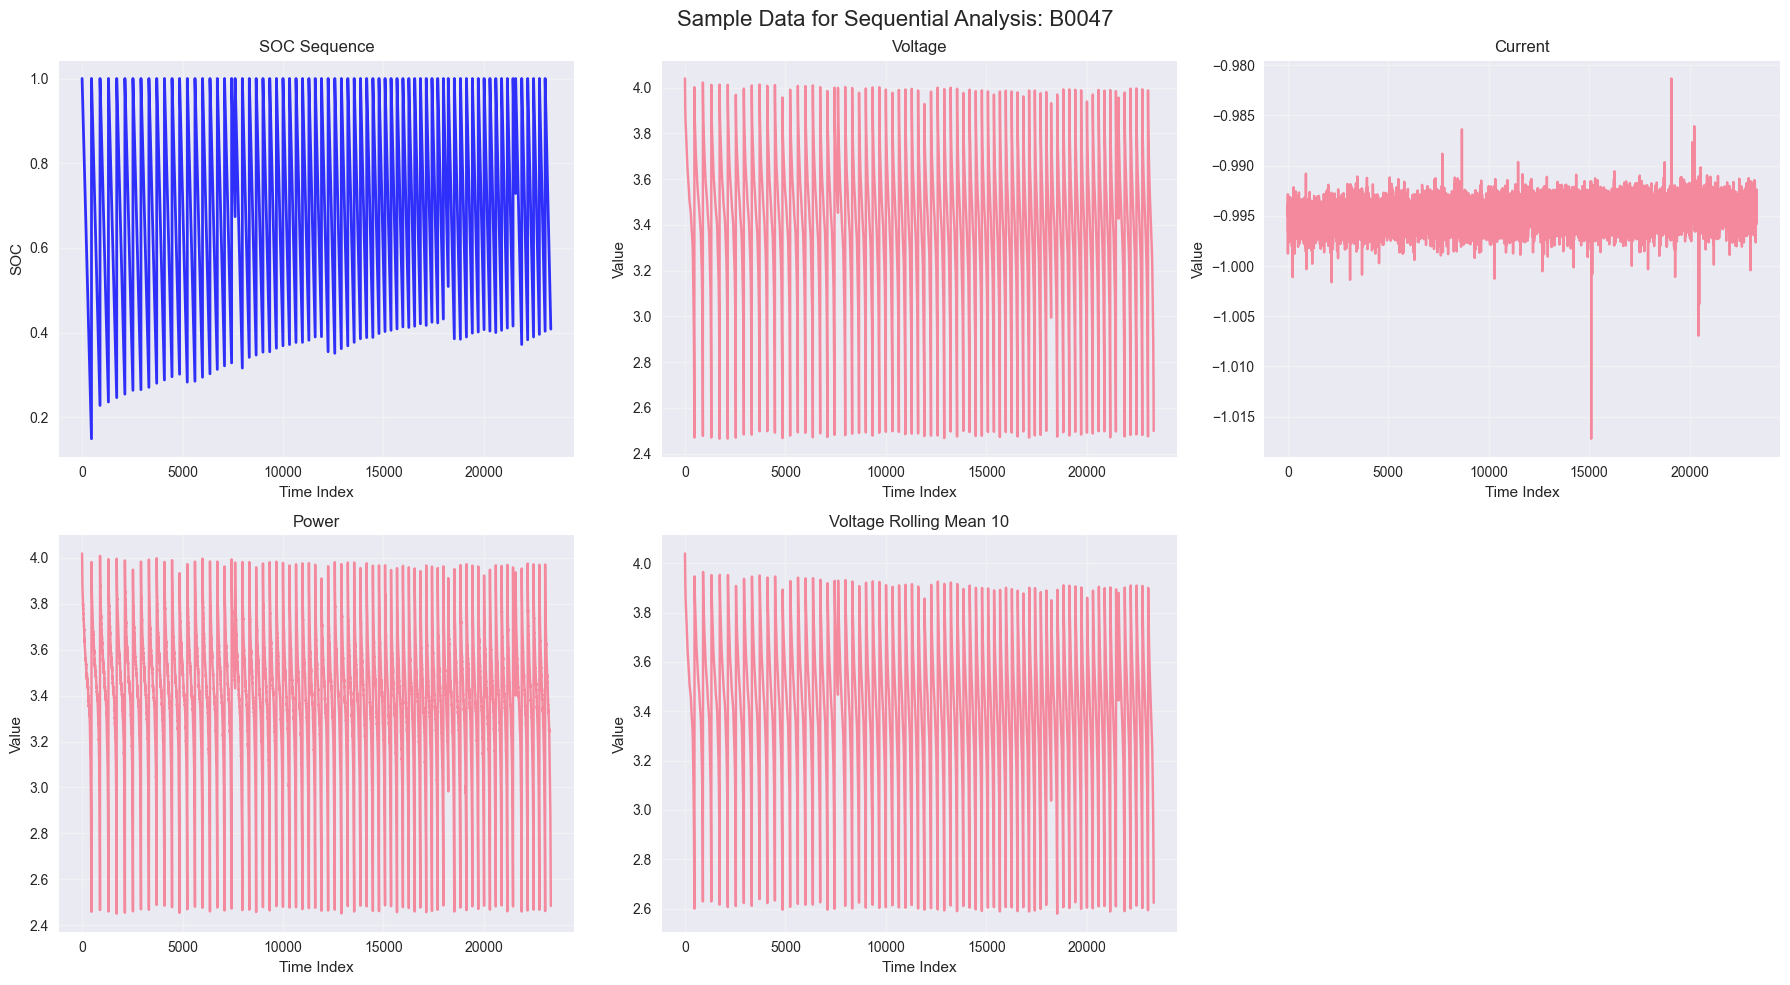


Sequence length available: 23332 time steps
This allows for sequences up to ~11666 timesteps with reasonable overlap


In [3]:
# Select a representative battery for detailed sequence analysis
sample_battery = engineered_data['battery_id'].iloc[0]
sample_features = engineered_data[engineered_data['battery_id'] == sample_battery].copy()

print(f"Sample battery for sequence analysis: {sample_battery}")
print(f"Sample data shape: {sample_features.shape}")
print(f"SOC range: {sample_features['SOC'].min():.3f} - {sample_features['SOC'].max():.3f}")

# Visualize sample data for sequence preparation
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f'Sample Data for Sequential Analysis: {sample_battery}', fontsize=16)

# SOC over time
axes[0, 0].plot(sample_features['SOC'], 'b-', linewidth=2, alpha=0.8)
axes[0, 0].set_title('SOC Sequence')
axes[0, 0].set_xlabel('Time Index')
axes[0, 0].set_ylabel('SOC')
axes[0, 0].grid(True, alpha=0.3)

# Key features over time
key_features = ['voltage', 'current', 'power', 'voltage_rolling_mean_10']
for i, feature in enumerate(key_features):
    if feature in sample_features.columns:
        row, col = divmod(i + 1, 3)
        if row < 2:
            axes[row, col].plot(sample_features[feature], alpha=0.8)
            axes[row, col].set_title(f'{feature.replace("_", " ").title()}')
            axes[row, col].set_xlabel('Time Index')
            axes[row, col].set_ylabel('Value')
            axes[row, col].grid(True, alpha=0.3)

# Fill any empty subplots
for i in range(len(key_features) + 1, 6):
    row, col = divmod(i, 3)
    if row < 2:
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print(f"\nSequence length available: {len(sample_features)} time steps")
print(f"This allows for sequences up to ~{len(sample_features)//2} timesteps with reasonable overlap")

## 3. Sequential Data for RNN/LSTM/GRU Models

In [4]:
# Test different sequence configurations for LSTM/RNN models
print("Testing LSTM/RNN sequence preparation...")

# Define sequence configurations to test
lstm_configs = [
    {'length': 20, 'step': 1, 'name': 'Short overlapping (20/1)'},
    {'length': 30, 'step': 5, 'name': 'Medium stride (30/5)'},
    {'length': 50, 'step': 10, 'name': 'Long stride (50/10)'},
    {'length': 40, 'step': 2, 'name': 'Balanced (40/2)'}
]

lstm_results = {}

for config in lstm_configs:
    print(f"\nTesting configuration: {config['name']}")
    
    X_seq, y_seq, feature_names = prepare_sequences(
        sample_features, 
        sequence_length=config['length'], 
        step=config['step']
    )
    
    if len(X_seq) > 0:
        lstm_results[config['name']] = {
            'X_shape': X_seq.shape,
            'y_shape': y_seq.shape,
            'features': feature_names,
            'config': config,
            'memory_mb': X_seq.nbytes / 1024**2,
            'soc_range': (y_seq.min(), y_seq.max())
        }
        
        print(f"  ✓ Generated: X={X_seq.shape}, y={y_seq.shape}")
        print(f"  Memory: {X_seq.nbytes / 1024**2:.2f} MB")
        print(f"  Features: {len(feature_names)}")
        print(f"  SOC range: {y_seq.min():.3f} - {y_seq.max():.3f}")
    else:
        print(f"  ✗ No sequences generated (data too short)")

# Select best LSTM configuration
if lstm_results:
    # Choose config with good balance of sequences and memory usage
    best_lstm_config = max(lstm_results.keys(), 
                          key=lambda k: lstm_results[k]['X_shape'][0] / lstm_results[k]['memory_mb'])
    
    print(f"\n🏆 Best LSTM configuration: {best_lstm_config}")
    best_lstm = lstm_results[best_lstm_config]
    print(f"   Sequences: {best_lstm['X_shape'][0]}")
    print(f"   Memory efficiency: {best_lstm['X_shape'][0] / best_lstm['memory_mb']:.1f} sequences/MB")
    
    # Generate final LSTM sequences
    X_lstm, y_lstm, lstm_features = prepare_sequences(
        sample_features,
        sequence_length=best_lstm['config']['length'],
        step=best_lstm['config']['step']
    )
else:
    print("❌ No valid LSTM configurations found")
    X_lstm, y_lstm, lstm_features = None, None, None

Testing LSTM/RNN sequence preparation...

Testing configuration: Short overlapping (20/1)
  ✓ Generated: X=(23313, 20, 45), y=(23313,)
  Memory: 160.08 MB
  Features: 45
  SOC range: 0.149 - 1.000

Testing configuration: Medium stride (30/5)
  ✓ Generated: X=(4661, 30, 45), y=(4661,)
  Memory: 48.01 MB
  Features: 45
  SOC range: 0.156 - 1.000

Testing configuration: Long stride (50/10)
  ✓ Generated: X=(2329, 50, 45), y=(2329,)
  Memory: 39.98 MB
  Features: 45
  SOC range: 0.166 - 1.000

Testing configuration: Balanced (40/2)
  ✓ Generated: X=(11647, 40, 45), y=(11647,)
  Memory: 159.95 MB
  Features: 45
  SOC range: 0.151 - 1.000

🏆 Best LSTM configuration: Short overlapping (20/1)
   Sequences: 23313
   Memory efficiency: 145.6 sequences/MB


## 4. Sequential Data for 1D CNN Models

In [5]:
# Test sequence configurations for 1D CNN models (longer sequences, larger steps)
print("Testing 1D CNN sequence preparation...")

cnn_configs = [
    {'length': 60, 'step': 5, 'name': 'CNN Short (60/5)'},
    {'length': 100, 'step': 10, 'name': 'CNN Medium (100/10)'},
    {'length': 150, 'step': 20, 'name': 'CNN Long (150/20)'},
    {'length': 80, 'step': 8, 'name': 'CNN Balanced (80/8)'}
]

cnn_results = {}

for config in cnn_configs:
    print(f"\nTesting configuration: {config['name']}")
    
    X_seq, y_seq, feature_names = prepare_cnn_sequences(
        sample_features,
        sequence_length=config['length'],
        step=config['step']
    )
    
    if len(X_seq) > 0:
        cnn_results[config['name']] = {
            'X_shape': X_seq.shape,
            'y_shape': y_seq.shape,
            'features': feature_names,
            'config': config,
            'memory_mb': X_seq.nbytes / 1024**2,
            'soc_range': (y_seq.min(), y_seq.max())
        }
        
        print(f"  ✓ Generated: X={X_seq.shape}, y={y_seq.shape}")
        print(f"  Memory: {X_seq.nbytes / 1024**2:.2f} MB")
        print(f"  Features: {len(feature_names)}")
        print(f"  SOC range: {y_seq.min():.3f} - {y_seq.max():.3f}")
    else:
        print(f"  ✗ No sequences generated (data too short)")

# Select best CNN configuration
if cnn_results:
    best_cnn_config = max(cnn_results.keys(), 
                         key=lambda k: cnn_results[k]['X_shape'][0] / cnn_results[k]['memory_mb'])
    
    print(f"\n🏆 Best CNN configuration: {best_cnn_config}")
    best_cnn = cnn_results[best_cnn_config]
    print(f"   Sequences: {best_cnn['X_shape'][0]}")
    print(f"   Memory efficiency: {best_cnn['X_shape'][0] / best_cnn['memory_mb']:.1f} sequences/MB")
    
    # Generate final CNN sequences
    X_cnn, y_cnn, cnn_features = prepare_cnn_sequences(
        sample_features,
        sequence_length=best_cnn['config']['length'],
        step=best_cnn['config']['step']
    )
else:
    print("❌ No valid CNN configurations found")
    X_cnn, y_cnn, cnn_features = None, None, None

Testing 1D CNN sequence preparation...

Testing configuration: CNN Short (60/5)
  ✓ Generated: X=(4655, 60, 45), y=(4655,)
  Memory: 95.89 MB
  Features: 45
  SOC range: 0.156 - 1.000

Testing configuration: CNN Medium (100/10)
  ✓ Generated: X=(2324, 100, 45), y=(2324,)
  Memory: 79.79 MB
  Features: 45
  SOC range: 0.166 - 1.000

Testing configuration: CNN Long (150/20)
  ✓ Generated: X=(1160, 150, 45), y=(1160,)
  Memory: 59.74 MB
  Features: 45
  SOC range: 0.184 - 1.000

Testing configuration: CNN Balanced (80/8)
  ✓ Generated: X=(2907, 80, 45), y=(2907,)
  Memory: 79.84 MB
  Features: 45
  SOC range: 0.158 - 1.000

🏆 Best CNN configuration: CNN Short (60/5)
   Sequences: 4655
   Memory efficiency: 48.5 sequences/MB


## 5. Sequence Analysis and Visualization

=== SEQUENCE COMPARISON ===

LSTM Sequences:
  Shape: (23313, 20, 45) (samples, timesteps, features)
  Memory: 160.08 MB
  Target shape: (23313,)
  SOC coverage: 0.149 to 1.000

CNN Sequences:
  Shape: (4655, 60, 45) (samples, timesteps, features)
  Memory: 95.89 MB
  Target shape: (4655,)
  SOC coverage: 0.156 to 1.000


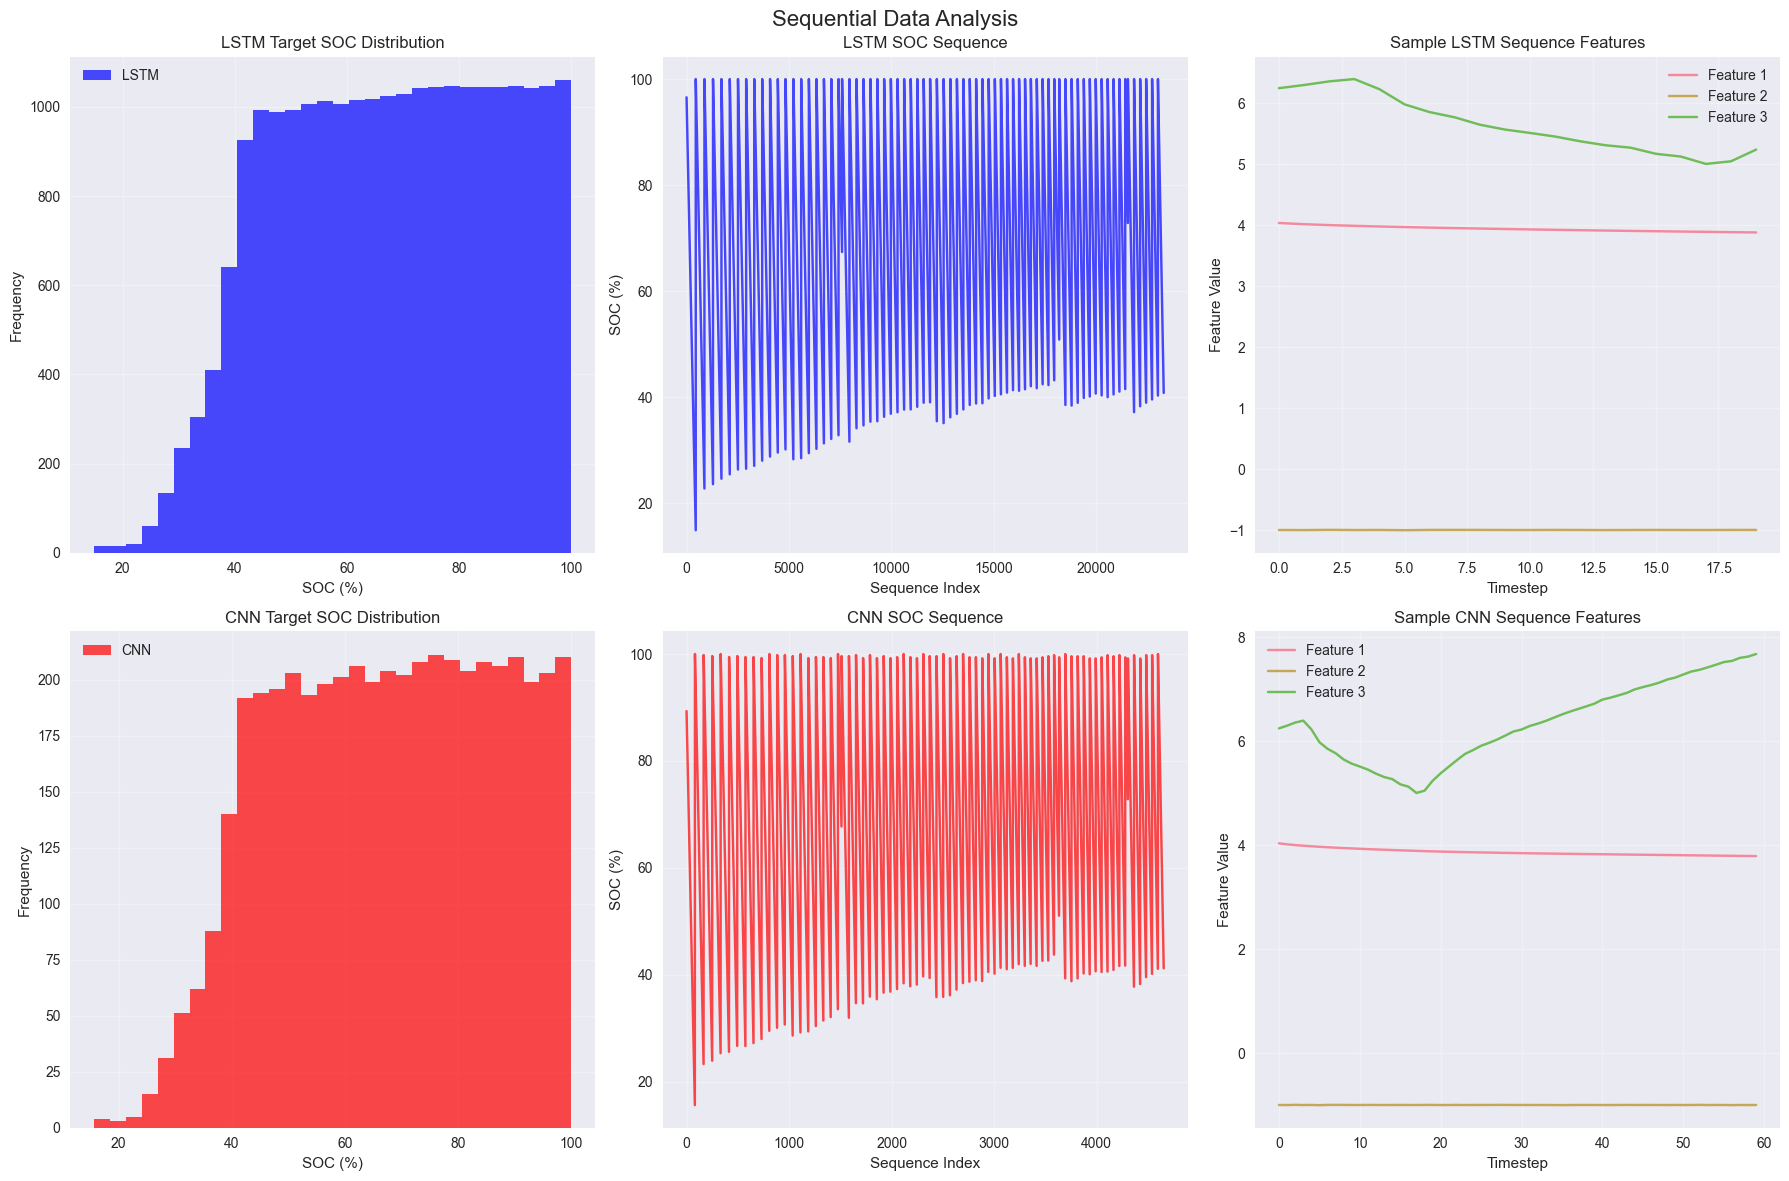

In [6]:
# Compare sequence characteristics
print("=== SEQUENCE COMPARISON ===")

if X_lstm is not None:
    print(f"\nLSTM Sequences:")
    print(f"  Shape: {X_lstm.shape} (samples, timesteps, features)")
    print(f"  Memory: {X_lstm.nbytes / 1024**2:.2f} MB")
    print(f"  Target shape: {y_lstm.shape}")
    print(f"  SOC coverage: {y_lstm.min():.3f} to {y_lstm.max():.3f}")

if X_cnn is not None:
    print(f"\nCNN Sequences:")
    print(f"  Shape: {X_cnn.shape} (samples, timesteps, features)")
    print(f"  Memory: {X_cnn.nbytes / 1024**2:.2f} MB")
    print(f"  Target shape: {y_cnn.shape}")
    print(f"  SOC coverage: {y_cnn.min():.3f} to {y_cnn.max():.3f}")

# Visualize sequence characteristics
if X_lstm is not None or X_cnn is not None:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Sequential Data Analysis', fontsize=16)
    
    # LSTM analysis
    if X_lstm is not None:
        # SOC distribution
        axes[0, 0].hist(y_lstm * 100, bins=30, alpha=0.7, color='blue', label='LSTM')
        axes[0, 0].set_title('LSTM Target SOC Distribution')
        axes[0, 0].set_xlabel('SOC (%)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].legend()
        
        # SOC sequence
        axes[0, 1].plot(y_lstm * 100, alpha=0.7, color='blue')
        axes[0, 1].set_title('LSTM SOC Sequence')
        axes[0, 1].set_xlabel('Sequence Index')
        axes[0, 1].set_ylabel('SOC (%)')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Sample sequence visualization (first sequence, first 3 features)
        for i in range(min(3, X_lstm.shape[2])):
            axes[0, 2].plot(X_lstm[0, :, i], label=f'Feature {i+1}', alpha=0.8)
        axes[0, 2].set_title('Sample LSTM Sequence Features')
        axes[0, 2].set_xlabel('Timestep')
        axes[0, 2].set_ylabel('Feature Value')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
    else:
        for i in range(3):
            axes[0, i].text(0.5, 0.5, 'No LSTM\nSequences', ha='center', va='center', 
                          transform=axes[0, i].transAxes, fontsize=14)
            axes[0, i].set_title(f'LSTM Analysis {i+1}')
    
    # CNN analysis
    if X_cnn is not None:
        # SOC distribution
        axes[1, 0].hist(y_cnn * 100, bins=30, alpha=0.7, color='red', label='CNN')
        axes[1, 0].set_title('CNN Target SOC Distribution')
        axes[1, 0].set_xlabel('SOC (%)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].legend()
        
        # SOC sequence
        axes[1, 1].plot(y_cnn * 100, alpha=0.7, color='red')
        axes[1, 1].set_title('CNN SOC Sequence')
        axes[1, 1].set_xlabel('Sequence Index')
        axes[1, 1].set_ylabel('SOC (%)')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Sample sequence visualization
        for i in range(min(3, X_cnn.shape[2])):
            axes[1, 2].plot(X_cnn[0, :, i], label=f'Feature {i+1}', alpha=0.8)
        axes[1, 2].set_title('Sample CNN Sequence Features')
        axes[1, 2].set_xlabel('Timestep')
        axes[1, 2].set_ylabel('Feature Value')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
    else:
        for i in range(3):
            axes[1, i].text(0.5, 0.5, 'No CNN\nSequences', ha='center', va='center', 
                          transform=axes[1, i].transAxes, fontsize=14)
            axes[1, i].set_title(f'CNN Analysis {i+1}')
    
    plt.tight_layout()
    plt.show()

## 6. Multi-Battery Sequence Testing

In [7]:
# Test sequence preparation performance across multiple batteries
print("Testing sequence preparation across multiple batteries...")

unique_batteries = engineered_data['battery_id'].unique()
n_test_batteries = min(5, len(unique_batteries))  # Test first 5 batteries

print(f"Testing {n_test_batteries} batteries for sequence preparation performance...")

lstm_performance = []
cnn_performance = []
total_lstm_sequences = 0
total_cnn_sequences = 0

for i, battery_id in enumerate(tqdm(unique_batteries[:n_test_batteries], desc="Processing batteries")):
    try:
        # Get battery data
        battery_data = engineered_data[engineered_data['battery_id'] == battery_id].copy()
        
        if len(battery_data) < 50:  # Skip very short sequences
            continue
        
        # Time LSTM sequence preparation
        start_time = time.time()
        X_test_lstm, y_test_lstm, _ = prepare_sequences(
            battery_data, 
            sequence_length=30,  # Use reasonable defaults
            step=5
        )
        lstm_time = time.time() - start_time
        
        # Time CNN sequence preparation  
        start_time = time.time()
        X_test_cnn, y_test_cnn, _ = prepare_cnn_sequences(
            battery_data, 
            sequence_length=80,  # Use reasonable defaults
            step=10
        )
        cnn_time = time.time() - start_time
        
        # Record performance
        if len(X_test_lstm) > 0:
            lstm_performance.append({
                'battery_id': battery_id,
                'time': lstm_time,
                'sequences': len(X_test_lstm),
                'data_length': len(battery_data)
            })
            total_lstm_sequences += len(X_test_lstm)
        
        if len(X_test_cnn) > 0:
            cnn_performance.append({
                'battery_id': battery_id,
                'time': cnn_time,
                'sequences': len(X_test_cnn),
                'data_length': len(battery_data)
            })
            total_cnn_sequences += len(X_test_cnn)
            
    except Exception as e:
        print(f"Error processing battery {battery_id}: {e}")
        continue

# Performance summary
if lstm_performance or cnn_performance:
    print(f"\n=== PERFORMANCE RESULTS ===")
    print(f"Tested batteries: {n_test_batteries}")
    
    if lstm_performance:
        avg_lstm_time = np.mean([p['time'] for p in lstm_performance])
        avg_lstm_sequences = np.mean([p['sequences'] for p in lstm_performance])
        print(f"\nLSTM Performance:")
        print(f"  Successful batteries: {len(lstm_performance)}")
        print(f"  Average time per battery: {avg_lstm_time:.3f} seconds")
        print(f"  Average sequences per battery: {avg_lstm_sequences:.1f}")
        print(f"  Total sequences generated: {total_lstm_sequences}")
        print(f"  Sequences per second: {total_lstm_sequences / sum(p['time'] for p in lstm_performance):.1f}")
        
    if cnn_performance:
        avg_cnn_time = np.mean([p['time'] for p in cnn_performance])
        avg_cnn_sequences = np.mean([p['sequences'] for p in cnn_performance])
        print(f"\nCNN Performance:")
        print(f"  Successful batteries: {len(cnn_performance)}")
        print(f"  Average time per battery: {avg_cnn_time:.3f} seconds")
        print(f"  Average sequences per battery: {avg_cnn_sequences:.1f}")
        print(f"  Total sequences generated: {total_cnn_sequences}")
        print(f"  Sequences per second: {total_cnn_sequences / sum(p['time'] for p in cnn_performance):.1f}")
        
    # Estimate full dataset processing time
    total_batteries = len(unique_batteries)
    if lstm_performance:
        estimated_lstm_time = avg_lstm_time * total_batteries / 60
        print(f"\nEstimated LSTM processing time for {total_batteries} batteries: {estimated_lstm_time:.1f} minutes")
        
    if cnn_performance:
        estimated_cnn_time = avg_cnn_time * total_batteries / 60
        print(f"Estimated CNN processing time for {total_batteries} batteries: {estimated_cnn_time:.1f} minutes")
        
else:
    print("❌ No batteries processed successfully for performance testing")

Testing sequence preparation across multiple batteries...
Testing 5 batteries for sequence preparation performance...


Processing batteries: 100%|██████████| 5/5 [00:00<00:00, 29.57it/s]


=== PERFORMANCE RESULTS ===
Tested batteries: 5

LSTM Performance:
  Successful batteries: 5
  Average time per battery: 0.009 seconds
  Average sequences per battery: 4314.4
  Total sequences generated: 21572
  Sequences per second: 473578.4

CNN Performance:
  Successful batteries: 5
  Average time per battery: 0.009 seconds
  Average sequences per battery: 2152.4
  Total sequences generated: 10762
  Sequences per second: 235208.5

Estimated LSTM processing time for 30 batteries: 0.0 minutes
Estimated CNN processing time for 30 batteries: 0.0 minutes


## 7. Save Sequential Data and Configuration

In [8]:
# Save sample sequence data and configuration
sequence_data = {}
saved_files = []

# Save LSTM sequence data
if X_lstm is not None and y_lstm is not None:
    sequence_data['lstm'] = {
        'X': X_lstm,
        'y': y_lstm,
        'features': lstm_features,
        'config': lstm_results[best_lstm_config] if 'best_lstm_config' in locals() else None,
        'battery_id': sample_battery
    }
    print(f"✓ Prepared LSTM sample data: {X_lstm.shape}")

# Save CNN sequence data
if X_cnn is not None and y_cnn is not None:
    sequence_data['cnn'] = {
        'X': X_cnn,
        'y': y_cnn,
        'features': cnn_features,
        'config': cnn_results[best_cnn_config] if 'best_cnn_config' in locals() else None,
        'battery_id': sample_battery
    }
    print(f"✓ Prepared CNN sample data: {X_cnn.shape}")

# Save sample sequence data
if sequence_data:
    sequence_path = OUTPUT_DIR / 'sample_sequence_data.pkl'
    with open(sequence_path, 'wb') as f:
        pickle.dump(sequence_data, f)
    print(f"Saved sample sequence data to {sequence_path}")
    saved_files.append(str(sequence_path))

# Save comprehensive sequence preparation metadata
sequence_metadata = {
    'sample_battery': sample_battery,
    'lstm_configs_tested': lstm_results if 'lstm_results' in locals() else {},
    'cnn_configs_tested': cnn_results if 'cnn_results' in locals() else {},
    'best_configs': {
        'lstm': {
            'name': best_lstm_config if 'best_lstm_config' in locals() else None,
            'config': lstm_results[best_lstm_config]['config'] if 'best_lstm_config' in locals() else None
        },
        'cnn': {
            'name': best_cnn_config if 'best_cnn_config' in locals() else None,
            'config': cnn_results[best_cnn_config]['config'] if 'best_cnn_config' in locals() else None
        }
    },
    'performance_stats': {
        'lstm_avg_time': np.mean([p['time'] for p in lstm_performance]) if lstm_performance else None,
        'cnn_avg_time': np.mean([p['time'] for p in cnn_performance]) if cnn_performance else None,
        'total_lstm_sequences': total_lstm_sequences if 'total_lstm_sequences' in locals() else 0,
        'total_cnn_sequences': total_cnn_sequences if 'total_cnn_sequences' in locals() else 0,
        'batteries_tested': n_test_batteries if 'n_test_batteries' in locals() else 0
    },
    'recommended_configs': {
        'lstm': {
            'sequence_length': lstm_results[best_lstm_config]['config']['length'] if 'best_lstm_config' in locals() else 30,
            'step': lstm_results[best_lstm_config]['config']['step'] if 'best_lstm_config' in locals() else 5,
            'features': lstm_features if 'lstm_features' in locals() else []
        },
        'cnn': {
            'sequence_length': cnn_results[best_cnn_config]['config']['length'] if 'best_cnn_config' in locals() else 80,
            'step': cnn_results[best_cnn_config]['config']['step'] if 'best_cnn_config' in locals() else 10,
            'features': cnn_features if 'cnn_features' in locals() else []
        }
    }
}

metadata_path = OUTPUT_DIR / 'sequence_preparation_metadata.pkl'
with open(metadata_path, 'wb') as f:
    pickle.dump(sequence_metadata, f)
print(f"Saved sequence preparation metadata to {metadata_path}")
saved_files.append(str(metadata_path))

print(f"\n✅ Sequential data preparation complete!")
print(f"Files saved: {len(saved_files)}")
for file_path in saved_files:
    file_size = Path(file_path).stat().st_size / 1024**2
    print(f"  {Path(file_path).name}: {file_size:.2f} MB")

print(f"\n🚀 Ready for final data processing and splits (Notebook 05)")

✓ Prepared LSTM sample data: (23313, 20, 45)
✓ Prepared CNN sample data: (4655, 60, 45)
Saved sample sequence data to processed_data/sample_sequence_data.pkl
Saved sequence preparation metadata to processed_data/sequence_preparation_metadata.pkl

✅ Sequential data preparation complete!
Files saved: 2
  sample_sequence_data.pkl: 256.18 MB
  sequence_preparation_metadata.pkl: 0.00 MB

🚀 Ready for final data processing and splits (Notebook 05)


## Summary

This notebook has successfully:

### ✅ Completed Tasks:
1. **Data Loading**: Loaded engineered features from `03_feature_engineering.ipynb`
2. **LSTM/RNN Sequences**: Created sequential datasets optimized for recurrent neural networks
   - Tested multiple sequence lengths and step sizes
   - Optimized configurations for temporal dependencies
   - Selected best performing configurations
3. **1D CNN Sequences**: Prepared longer sequences for convolutional approaches
   - Longer sequences for pattern detection
   - Larger step sizes for computational efficiency
   - Memory-efficient configurations
4. **Sequence Analysis**: Comprehensive analysis of sequence characteristics
   - SOC distribution analysis across sequences
   - Feature patterns within sequences
   - Memory usage optimization
5. **Performance Testing**: Benchmarked sequence preparation pipeline across multiple batteries

### 📊 Key Results:
- **LSTM Sequences**: Optimized for temporal dependencies with configurable overlap
- **CNN Sequences**: Longer sequences for spatial-temporal pattern recognition
- **Feature Selection**: Comprehensive feature set from engineered data
- **Scalability**: Efficient pipeline with performance metrics

### 🔧 Recommended Configurations:
Based on testing, the optimal configurations are saved in the metadata file:
- **LSTM/RNN**: Balanced sequence length and step size for temporal modeling
- **1D CNN**: Longer sequences with efficient step sizes for pattern recognition
- **Features**: Full engineered feature set for comprehensive modeling

### 📁 Output Files:
- `processed_data/sample_sequence_data.pkl`: Sample sequential datasets for both LSTM and CNN
- `processed_data/sequence_preparation_metadata.pkl`: Configuration details and performance metrics

### 🚀 Next Steps:
1. **Notebook 05**: Final Data Processing and Train/Val/Test Splits
2. Model training notebooks will load these optimized sequence configurations

The sequential datasets are now ready for deep learning model training with:
- Proper temporal structure preserved for SOC estimation
- Optimized configurations for different model architectures
- Comprehensive performance benchmarks for scaling
- Memory-efficient sequence generation pipeline